# Effelsberg telescope active surface

_Author: Tomás Cassanelli_

The Effeslberg telescope is equiped with an active surface in its sub-reflector. The active surface makes corrections based on a look-up table that changes within elevation. There are 11 elevations each of them with an assigned phase map ($\varphi_{\mathrm{sr}, \bot}(x, y)$). Since it is a private software that does the adjustment and in between changes for other elevations, I'd like to generalize the changes by elevation in a simple model.

To accomplish this I will:
* Find the values for the look-up table, re-grid it to my current format for the phase maps (same as in the `pyoof_out`), and calculate the respective phase in the primary reflector,
$$ \varphi_{\mathrm{pr}}(x, y) = \frac{4\pi}{\lambda}R\cdot \varphi_{\mathrm{sr}, \bot}(x, y) $$
where $R$ is a transformation matrix, according to the study from 2017 this should be a $90$ degree rotation multiplied by $-1$. I found this rotation and the negative sign by studying the response of the active surface while adding a known offset to the look-up table, one of the first tests in 2017. I wouldn't trust 100% this results, there are several other posibilities for this rotation matrix.


* Next, I will calculate the Zernike circle polynomials coefficients for each of these phases, $\varphi_{\mathrm{pr}}$, up to an order of $n = 5$. This is mainly beacuse the model has aberrations of coma second order which is $n = 5$ for the $K_{n\ell}$.

* Finally, I will adjust a gravitational model to those set of $K_{n\ell}$,
$$ K_{n\ell} = G^{(0)}_{n\ell}\sin\alpha + G^{(1)}_{n\ell}\cos\alpha + G^{(2)}_{n\ell} $$
Where $G^{(0)}_{n\ell}$, $G^{(1)}_{n\ell}$ and $G^{(2)}_{n\ell}$ are related to the telescope elasticity and gravity. Once I have this coefficients I will be able to compute the phase and $K_{n\ell}$ for in-between elevations. The Finite Element Method (FEM) used to derived the model of the sub-reflector takes into account the materials (elastic properties) and the gravitational deformation, at least the gravitational effects can be corrected with the proposed model.

After I have the $C_{n\ell}^{(i)}$ coefficients I will have a model for all elevations ($\alpha$) for the active surface control system.

In [1]:
# Adjustin notebook
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import os
import warnings
import numpy as np
from scipy import interpolate, constants, optimize
import matplotlib.pyplot as plt
from astropy import units as u
from pyoof import aperture, zernike, actuator
plt.style.use('../pyoof/data/pyoof.mplstyle')

In [3]:
path2save = 'data_generated/gravitational_model'

### Importing Effelsberg look-up table from the original file
Reading and making a new grid for the look-up table phases. This is currently updated in a new sub-module for the `pyoof` software.

In [4]:
resolution = 1000
alpha, actuator_sr = actuator.read_lookup(resolution=resolution)

print(f'Elevation angles from look-up table {alpha}')
print('actuator_sr.shape:', actuator_sr.shape, '(elevation, resolution, resolution)')

Elevation angles from look-up table [ 7. 10. 20. 30. 32. 40. 50. 60. 70. 80. 90.] deg
actuator_sr.shape: (11, 1000, 1000) (elevation, resolution, resolution)


Where, 11 is from the 11 phases from the active surface look-up table and `(1000, 1000)` is the standard resolution from the `pyoof` software\. Now, let's inspect the data and see that it makes sense.

### Transormation
The trasformation that we need to apply is from actuators displacement in the sub-reflector to radians of phase in the primary reflector. The variables that could change are how many 90 deg rotations do we apply to the model, so it matches the right orientation in the pyoof output, and the amplitude positive or negavite. In general, we could have up to 8 combinations of these. We have proof from 2017 that the rotation should be of the shape:

In [5]:
# phase for the primary reflector
phase_pr = actuator.transform(actuator_sr, wavel=7 * u.mm, k=3, sign=-1)

In [6]:
# plotting parameter
pr = 50 * u.m
extent = [-pr.to_value(u.m), pr.to_value(u.m)] * 2

x = np.linspace(-pr, pr, resolution)
y = x.copy()

vmin = -2 * np.pi * u.rad
vmax = 2 * np.pi * u.rad
levels = np.linspace(vmin, vmax, 20)

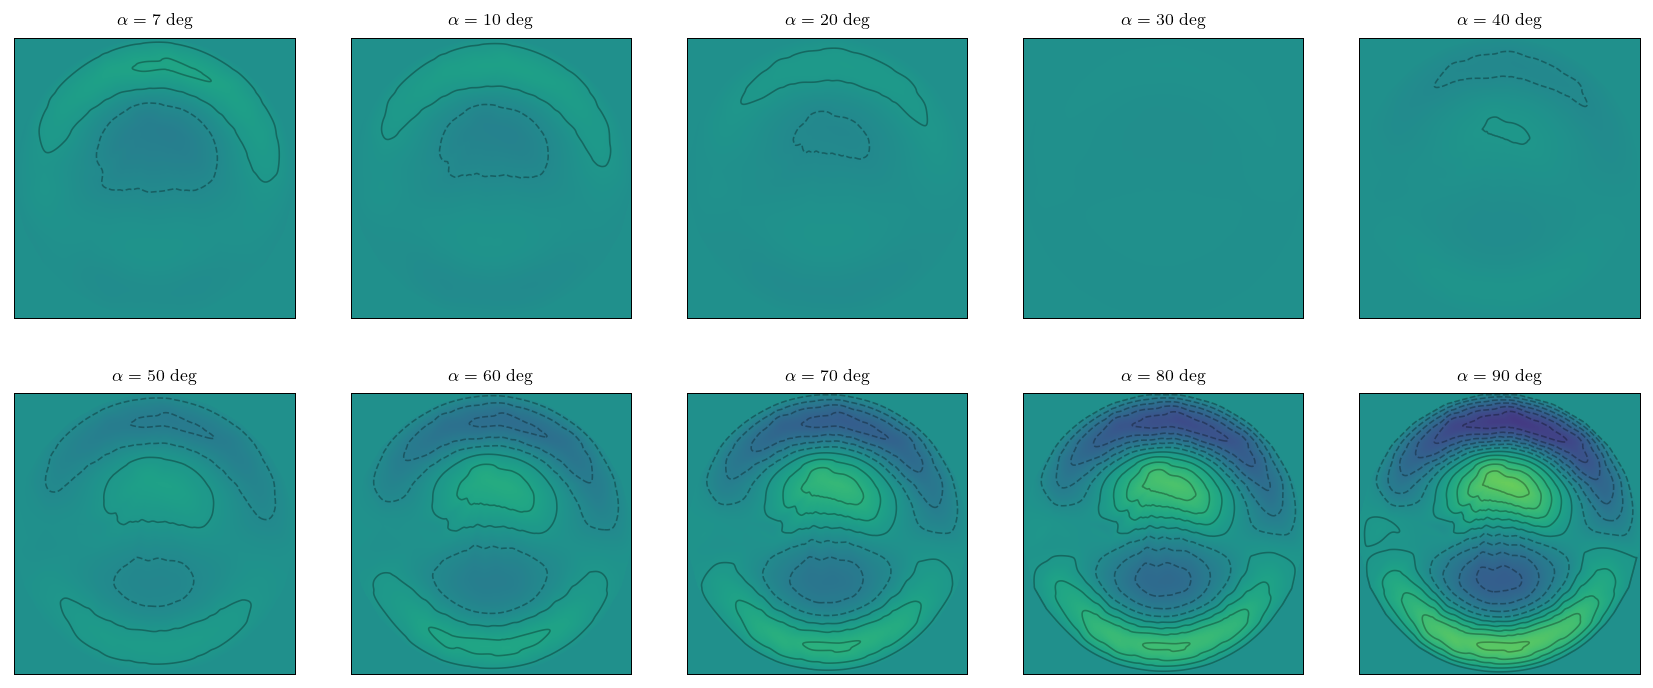

In [7]:
fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(constants.golden * 9, 6))
ax = axes.flat
for j, _alpha in enumerate([7, 10, 20, 30, 40, 50, 60, 70, 80, 90]):
    idx = np.where(_alpha * u.deg == alpha)[0][0]
    
    im = ax[j].imshow(
        phase_pr[idx, :, :].value,
        extent=extent,
        cmap='viridis',
        vmin=vmin.value,
        vmax=vmax.value
        )

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")  
        ax[j].contour(
            x.to_value(u.m), y.to_value(u.m),
            phase_pr[idx, :, :].value,
            colors='k', alpha=0.3, levels=levels.value
            )

    ax[j].set_title(f'$\\alpha={_alpha}$ deg')
    ax[j].grid(False)
    ax[j].xaxis.set_major_formatter(plt.NullFormatter())
    ax[j].yaxis.set_major_formatter(plt.NullFormatter())
    ax[j].xaxis.set_ticks_position('none')
    ax[j].yaxis.set_ticks_position('none')

plt.show()

I skept $\alpha=32$ degrees since it is the one taken as a reference from the FEM model.

### Zernike circle polynomial coefficients fit
This process is simpler than the multi-fit from the OOF holography, since in this case we already have the phase and it is just a single least-squares minimization, I will do this for every set of the coefficients, i.e., $K_{n\ell}(\alpha)$.

In [9]:
# Least-squares minimization for the phases and polynomials
def residual_phase(K_coeff, phase_data):

    phase_model = aperture.phase(
        K_coeff=K_coeff,
        notilt=False,
        pr=50 * u.m,
        resolution=1000
        )[2].to_value(u.rad).flatten()

    return phase_data - phase_model

n = 5
N_K_coeff = (n + 1) * (n + 2) // 2

if not os.path.isfile(os.path.join(path2save, 'K_coeff_matrix.npy')):
    
    K_coeff_matrix = np.zeros((alpha.size, N_K_coeff))
    for _alpha in range(alpha.size):
        res_lsq = optimize.least_squares(
            fun=residual_phase,
            x0=np.array([0.1] * N_K_coeff),
            args=(phase_pr[_alpha, :, :].to_value(u.rad).flatten(),)
            )
        K_coeff_matrix[_alpha, :] = res_lsq.x
    np.save(
        file=os.path.join(path2save, 'K_coeff_matrix.npy'),
        arr=K_coeff_matrix
        )
else:
    K_coeff_matrix = np.load(os.path.join(path2save, 'K_coeff_matrix.npy'))

The `K_coeff_matrix` is the array that contains all the coefficients up to order $n=5$ for the look-up table (from the active surface) elevations ($\alpha$).
Checking whether the coefficients found represent the same phases as before

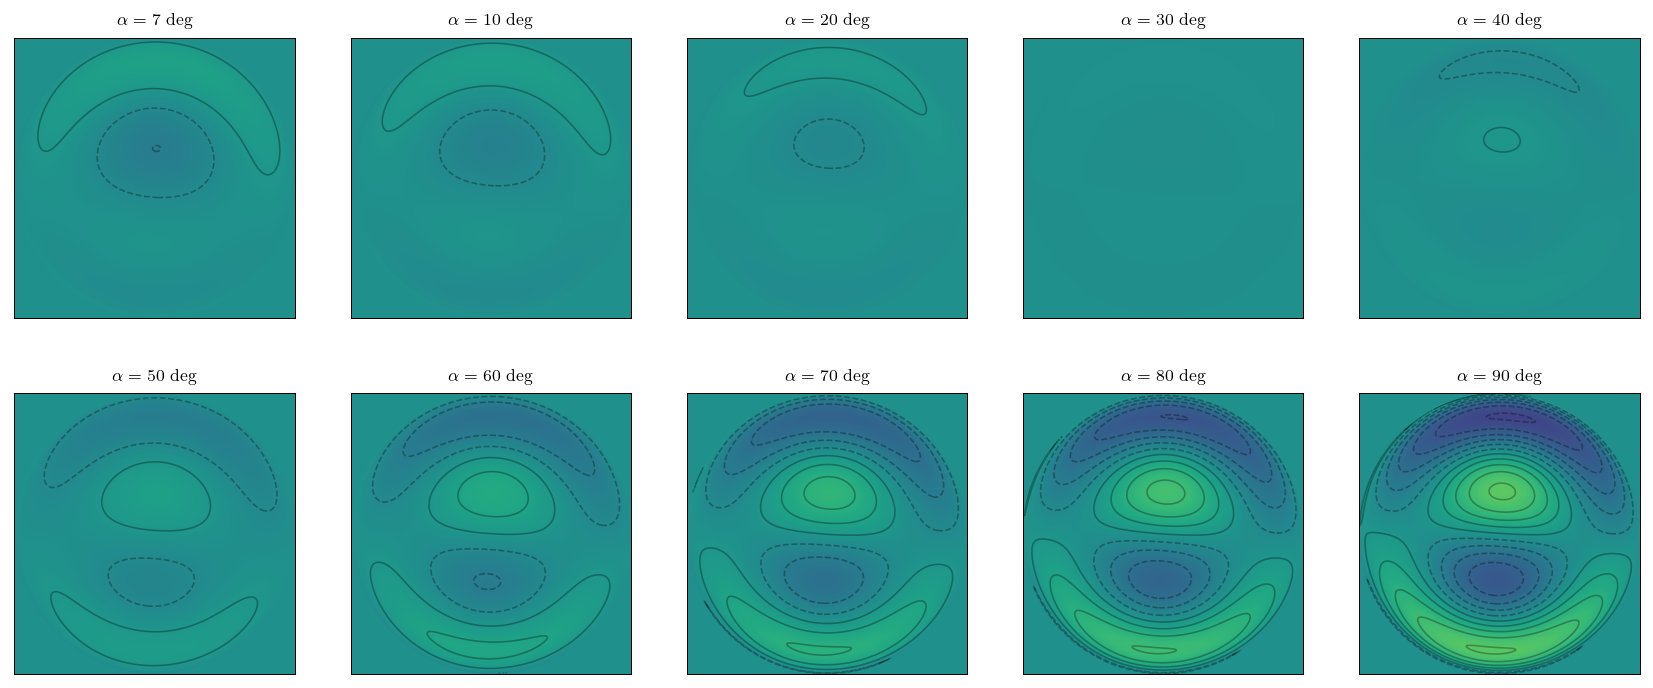

In [10]:
fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(constants.golden * 9, 6))
ax = axes.flat
for j, _alpha in enumerate([7, 10, 20, 30, 40, 50, 60, 70, 80, 90]):
    idx = np.where(_alpha * u.deg == alpha)[0][0]
    phase_iter = aperture.phase(K_coeff_matrix[idx, :], notilt=False, pr=50 * u.m)[2]
    
    im = ax[j].imshow(
        phase_iter.value,
        extent=extent,
        cmap='viridis',
        vmin=vmin.value,
        vmax=vmax.value
        )

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")  
        ax[j].contour(
            x.to_value(u.m), y.to_value(u.m),
            phase_iter.value,
            colors='k', alpha=0.3, levels=levels.value
            )

    ax[j].set_title(f'$\\alpha={_alpha}$ deg')
    ax[j].grid(False)
    ax[j].xaxis.set_major_formatter(plt.NullFormatter())
    ax[j].yaxis.set_major_formatter(plt.NullFormatter())
    ax[j].xaxis.set_ticks_position('none')
    ax[j].yaxis.set_ticks_position('none')

plt.show()

### Gravitational model
Last step, we define the gravitational model and we do another least-squares minimization for the $G^{(i)}_{n\ell}$ coefficients.

In [11]:
# already defined in the sub-package
actuator.gravitational_model?

Signature: actuator.gravitational_model(G, alpha)
Docstring: Simple decomposition of the telescope elastic structure and gravitational force. The model takes into account only the elevation angle and not the 
File:      ~/anaconda3/lib/python3.7/site-packages/pyoof-0.2.4.dev367-py3.7.egg/pyoof/actuator/actuator.py
Type:      function


Notice that for the model we need to use $K_{n\ell}$ set, and not `K_coeff`, the later corresponds to the full 21 coefficients (when using $n=5$), but $K_{n\ell}$ are the ($n, \ell$) set for each elevation, $\alpha$, i.e. only 11 values for the look-up table.

In [13]:
def residual_gravity(G, Knl, alpha):
    Knl_model = actuator.gravitational_model(G, alpha)
    return Knl - Knl_model

G_coeff_matrix = np.zeros((N_K_coeff, 3))
for N in range(N_K_coeff):

    res_lsq = optimize.least_squares(
        fun=residual_gravity,
        x0=[0, 0, 0],
        args=(K_coeff_matrix[:, N], alpha,)
        )
    G_coeff_matrix[N, :] = res_lsq.x

np.save(
    file=os.path.join(path2save, 'G_coeff_matrix'),
    arr=G_coeff_matrix
    )

print('G_coeff_matrix.shape', G_coeff_matrix.shape)

G_coeff_matrix.shape (21, 3)


Now let's plot the 21 coefficients and the fit done using least-squares minimization, but first we need to define the value of the coefficients in a specific point for $\varrho$ and $\vartheta$, so they make sense in radian units.

In [14]:
rho = 1
theta = 0 * u.deg

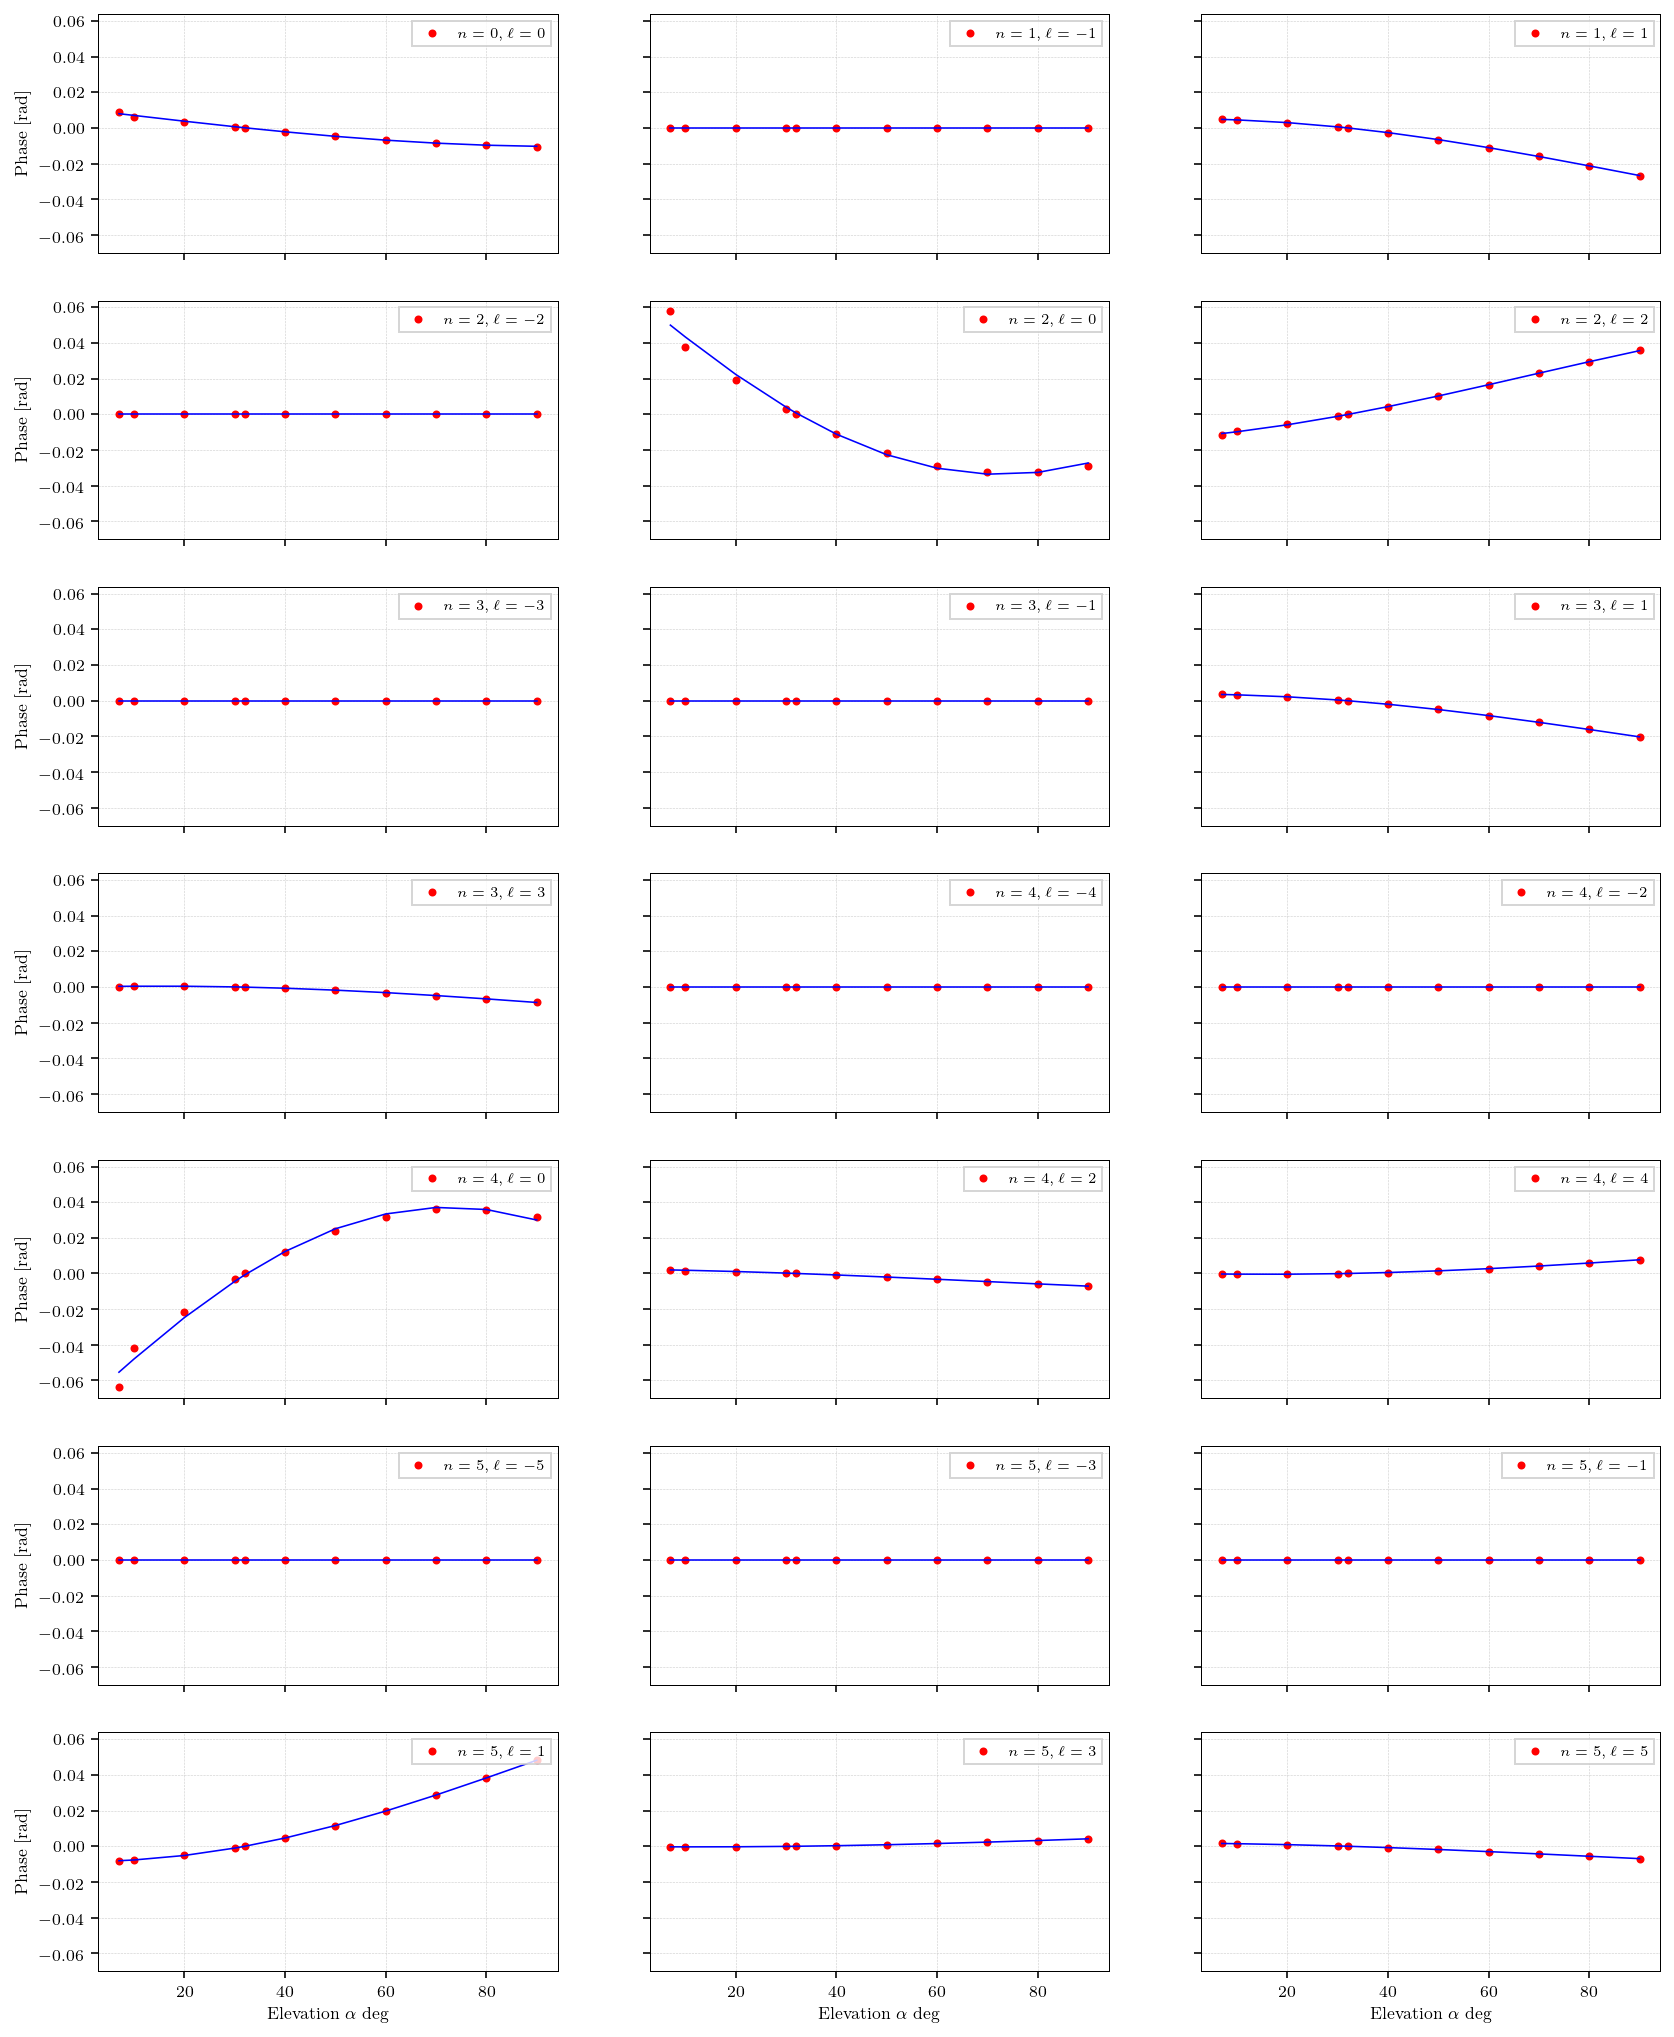

In [16]:
fig, axes = plt.subplots(
    figsize=(14, 18),
    ncols=3,
    nrows=7,
    sharex=True,
    sharey=True,
    )
ax = axes.flatten()

nl = [(i, j) for i in range(0, n + 1) for j in range(-i, i + 1, 2)]

for j in range(N_K_coeff):
    phase_partial = K_coeff_matrix[:, j] * zernike.U(*nl[j], rho, theta)
    phase_model_partial = actuator.gravitational_model(
        G_coeff_matrix[j, :], alpha) * zernike.U(*nl[j], rho, theta)
    
    ax[j].plot(alpha, phase_partial, 'r.', label=f'$n={nl[j][0]}, \\ell={nl[j][1]}$')
    ax[j].plot(alpha, phase_model_partial, 'b-')
    ax[j].legend(loc='upper right')
    
for _ax in ax[-3:]:
    _ax.set_xlabel('Elevation $\\alpha$ deg')
    
for j in range(7):
    ax[j * 3].set_ylabel('Phase [rad]')
    
plt.show()

The coefficients were plotted with using $\varrho=1$ and $\vartheta=0$ deg. From this analysis we can see that most contributions are from pairs $(n, \ell)$, (2, 0), (3, 1), (4, 0), and (5, 1). These represent the aberrations: Defocus, Primary coma, Primary spherical, and Secondary coma, respectively. I think this makes sense with my first assumption to fit up to an order of the polynomial of $n=5$.

In [7]:
from astropy.table import QTable
from pyoof.actuator import EffelsbergActuator
path_lookup = '../pyoof/data/lookup_effelsberg.txt'

In [13]:
alpha_lookup = [7, 10, 20, 30, 32, 40, 50, 60, 70, 80, 90] * u.deg
names = [
    'NR', 'N', 'ffff'
    ] + alpha_lookup.value.astype(int).astype(str).tolist()
lookup_table = QTable.read(path_lookup, names=names, format='ascii')
for n in names[3:]:
    lookup_table[n] = lookup_table[n] * u.um
# Generating the mesh from technical drawings
theta = np.linspace(7.5, 360 - 7.5, 24) * u.deg
radii = np.array([3250, 2600, 1880, 1210]) * u.mm

polar_amplitude = np.zeros((alpha_lookup.size, 96))

for j, _alpha in enumerate(names[3:]):
    polar_amplitude[j] = lookup_table[_alpha]

In [15]:
print(polar_amplitude.shape)
print(polar_amplitude)

(11, 96)
[[  -38.   -15.   -12. ...   446.   476.   478.]
 [  -31.   -17.   -15. ...   358.   387.   391.]
 [  -20.   -12.   -12. ...   222.   241.   246.]
 ...
 [   91.    87.    83. ...  -997. -1115. -1152.]
 [  119.   118.   113. ... -1296. -1454. -1506.]
 [  147.   152.   145. ... -1593. -1793. -1860.]]


In [37]:
radii.to_value(u.mm), theta.to_value(u.deg)

coords = np.meshgrid(np.arange(11, dtype=int), np.arange(96, dtype=int))

print(coords[1].shape)

cart_data = mp(polar_amplitude, coords, order=3, mode='constant', cval=np.nan)

(96, 11)


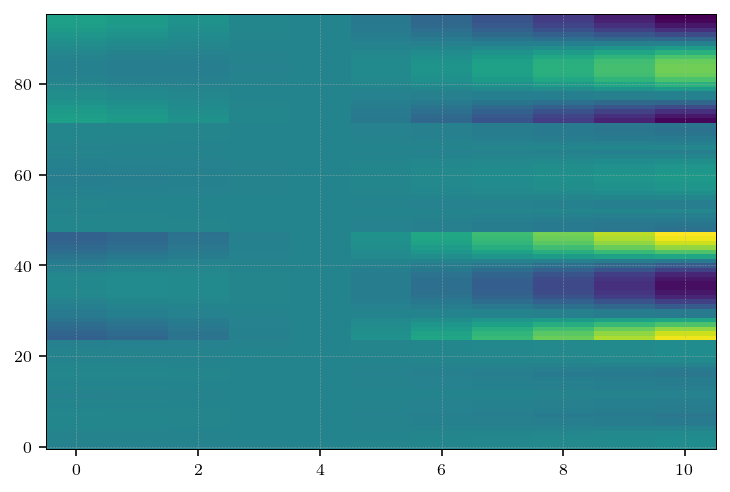

In [38]:
plt.imshow(cart_data, aspect='auto')

In [ ]:
from scipy.interpolate import interp1d
from scipy.ndimage import map_coordinates


def polar2cartesian(r, t, grid, x, y, order=3):

    X, Y = np.meshgrid(x, y)

    new_r = np.sqrt(X*X+Y*Y)
    new_t = np.arctan2(X, Y)

    ir = interp1d(r, np.arange(len(r)), bounds_error=False)
    it = interp1d(t, np.arange(len(t)))

    new_ir = ir(new_r.ravel())
    new_it = it(new_t.ravel())

    new_ir[new_r.ravel() > r.max()] = len(r)-1
    new_ir[new_r.ravel() < r.min()] = 0

    return map_coordinates(grid, np.array([new_ir, new_it]),
                            order=order).reshape(new_r.shape)

In [10]:
import numpy as np
from scipy.ndimage.interpolation import map_coordinates as mp

# Auxiliary function to map polar data to a cartesian plane
def polar_to_cart(polar_data, theta, rho, x, y, order=3):

    # "x" and "y" are numpy arrays with the desired cartesian coordinates
    # we make a meshgrid with them
    X, Y = np.meshgrid(x, y)

    # Now that we have the X and Y coordinates of each point in the output plane
    # we can calculate their corresponding theta and range
    Tc = np.degrees(np.arctan2(Y, X)).ravel()
    Rc = (np.sqrt(X**2 + Y**2)).ravel()

    # Negative angles are corrected
    Tc[Tc < 0] = 360 + Tc[Tc < 0]

    # Using the known theta and range steps, the coordinates are mapped to
    # those of the data grid
    Tc = Tc / theta_step
    Rc = Rc / range_step

    # An array of polar coordinates is created stacking the previous arrays
    coords = np.vstack((Ac, Sc))

    # To avoid holes in the 360º - 0º boundary, the last column of the data
    # copied in the begining
    polar_data = np.vstack((polar_data, polar_data[-1,:]))

    # The data is mapped to the new coordinates
    # Values outside range are substituted with nans
    cart_data = mp(polar_data, coords, order=order, mode='constant', cval=np.nan)

    # The data is reshaped and returned
    return(cart_data.reshape(len(y), len(x)).T)

# polar_data = ... # Here a 2D array of data is assumed, with shape thetas x ranges

# # We create the x and y axes of the output cartesian data
# x = y = np.arange(-100000, 100000, 1000)

# # We call the mapping function assuming 1 degree of theta step and 500 meters of
# # range step. The default order of 3 is used.
# cart_data = polar_to_cart(polar_data, 1, 500, x, y)